In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of experimental sRNA circuit data

## Imports

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import ViennaRNA
from varnaapi import Structure
import seaborn as sns
import matplotlib.pyplot as plt

from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA


module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

In [3]:
from src.utils.visualisation import show_rna_structure  


## Load data

In [4]:
fn_mutations = 'data/scott_mutations.fasta'
muts = load_seq_from_FASTA(fn_mutations, as_type='dict')

In [5]:
index = ['synChiX', 'Mutant 16', 'Mutant 18', 'Mutant 60', 'Mutant 27', 'Mutant 39', 'Mutant 164']
index_conv = {k: v for k, v in zip(index, ['Syn_ChiX_20-D', 'MutagenesisVariant_16', 'MutagenesisVariant_18', 'MutagenesisVariant_60', 'MutagenesisVariant_27', 'MutagenesisVariant_39', 'MutagenesisVariant_164'])}
cols = ['Mutant', 'DG EGFP', 'DG cyRFP', 'BP n EGFP', 'BP n cyRFP', 'FC Vanillic Acid (EGFP)', 'FC IPTG (cyRFP)', 'FC OC6 1 (EGFP)', 'FC OC6 2 (EGFP)', 'FC OC6 1 (cyRFP)', 'FC OC6 2 (cyRFP)', 'Plate FC OC6 (cyRFP)', 'Plate FC OC6 (EGFP)', 'Diff DG EGFP', 'Diff DG cyRFP', 'Diff BP EGFP', 'Diff BP cyRFP', 'Tot FC EGFP', 'Tot FC cyRFP', 'Tot Plate EGFP', 'Tot Plate cyRFP']
data = np.array(['synChiX', -29, -7, 21, 7, 1, 1, 0.3, 0.25, 1.1, 1.7, 0.54, 0.42, 0, 0, 0, 0, 0.25, 1.7, 0.42, 0.54, 
                 'Mutant 16', -23, -10.5, 20, 11, 1, 1, 0.2, 0.15, 1.1, 1.6, 0.25, 0.8, 6, -3.5, -1, 4, 0.15, 1.6, 0.8, 0.25, 
                 'Mutant 18', -23.5, -12.1, 20, 16, 1.1, 1, 0.7, 0.6, 1.4, 2, 0.33, 0.83, 5.5, -5.1, -1, 9, 0.545, 2, 0.83, 0.33, 
                 'Mutant 60', -28, -7, 22, 8, 1, 1, 0.3, 0.2, 1.1, 1.4, 0.4, 0.52, 1., 0., 1, 1, 0.2, 1.4 , 0.52, 0.4, 
                 'Mutant 27', -24.5, -9.5, 22, 24, 1, 1, 0.2, 0.15, 1, 1.4, 0.3, 0.52, 4.5, -2.5, 1, 17, 0.15, 1.4, 0.52, 0.3, 
                 'Mutant 39', -25, -5, 22, 7, 1, 1, 0.65, 0.4, 1.6, 3.6, 0.57, 0.26, 4., 2., 1, 0, 0.4, 3.6, 0.26, 0.57, 
                 'Mutant 164', -32, -8.5, 20, 7, 1, 1, 0.2, 0.15, 1, 1.3, 0.44, 0.27, -3, -1.5, -1, 0, 0.15, 1.3, 0.27, 0.44])
data = data.reshape((7, len(cols)))
data = pd.DataFrame(data=data, columns=cols, index=index)
data[cols[1:]] = data[cols[1:]].apply(lambda x: list(map(lambda xx: float(xx), x)))

for c in ["Tot FC EGFP","Tot FC cyRFP","Tot Plate EGFP","Tot Plate cyRFP"]: 
    data[c.replace('Tot', 'Ratio')] = data[c].iloc[0] - data[c]

In [6]:
submuts = {k: v for k, v in muts.items() if k in index_conv.values()}

## DG SynChiX

<Axes: >

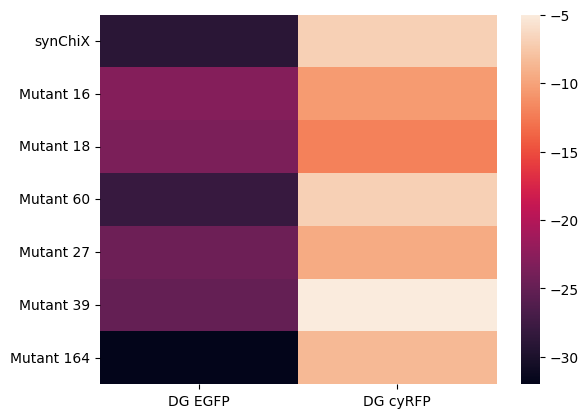

In [7]:
sns.heatmap(data[['DG EGFP', 'DG cyRFP']])

Text(0.5, 1.0, 'Relative fold change of mutants to synChiX (log)')

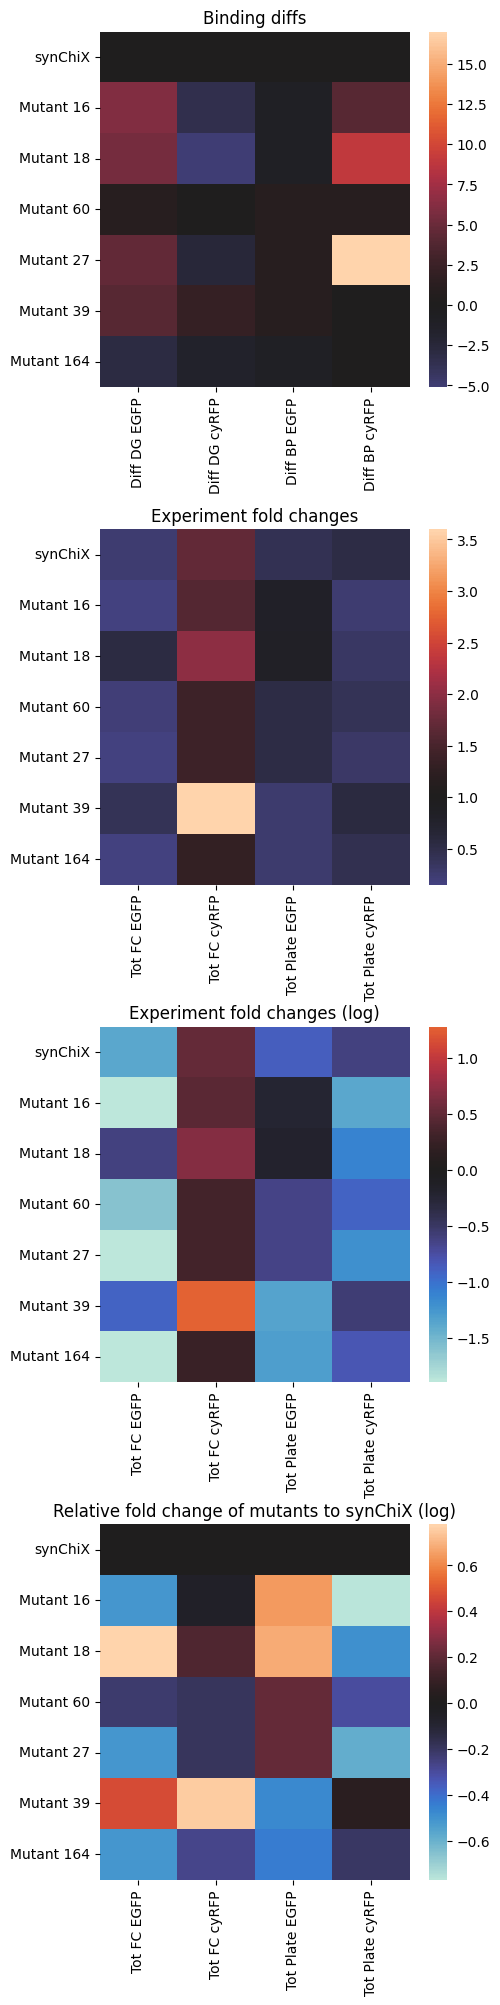

In [8]:
fig = plt.figure(figsize=(5, 4*6))
fig.subplots_adjust(wspace=0.4, hspace=0.4)
ax = plt.subplot(4,1,1)
sns.heatmap(data[[c for c in data.columns if ('Diff' in c)]], center=0)
plt.title('Binding diffs')
ax = plt.subplot(4,1,2)
sns.heatmap(data[[c for c in data.columns if ('Tot' in c)]], center=1)
plt.title('Experiment fold changes')
ax = plt.subplot(4,1,3)
sns.heatmap(np.log(data[[c for c in data.columns if ('Tot' in c)]]), center=0)
plt.title('Experiment fold changes (log)')
ax = plt.subplot(4,1,4)
sns.heatmap(np.log(data[[c for c in data.columns if ('Tot' in c)]] / data[[c for c in data.columns if ('Tot' in c)]].loc['synChiX']), center=0)
plt.title('Relative fold change of mutants to synChiX (log)')


# Interpretation

The above graphs are a summary of how the experimental data relates to the design attributes of the sRNA, based on ChiX as a template.

## Looking at absolute log fold changes
Hypothesis: sRNA represses GFP by binding its mRNA
- Expectations:
    1. All synChiX variations should result in negative log fold change of GFP 
    2. The degree of repression should be proportional to DG
- Reality
    1. (MIXED) 
        - (PRO) All log fold changes of GFP are negative for chi.Bio 
        - (CONTRA) All log fold changes of GFP are negative for plate reader EXCEPT Mutant 16 and 18
    2. (MIXED)
        - (CONTRA) Mutant 16 & 18 and 27 & 39 have similar DG, but very different log fold changes in Chi.Bio
        - (PRO) The absolute fold changes don't differ too much in both Chi.Bio and plate reader
- Conclusions
    1. Possibilities for Mutant 16 and 18:
        - The mutants were too weak to bind GFP mRNA in moderate conditions. 
            - (CONTRA) This would be surprising, as both have a predicted DG more negative than -20 kcal/mol.
        - The increased binding to RFP caused these mutants to have no effect on GFP mRNA binding because of competition.
            - (PRO) Both have a very negative log fold change in RFP in the plate reader
            - (PRO) Mutant 18 has a more positive *relative* log FC even in the Chi.Bio GFP
            

## Looking at relative fold change (FC)
Given the following hypothesis: the sRNA represses GFP by binding 
- Expectations:
    1. We expect that mutants with stronger GFP binding E lead to a more negative relative log fold change for GFP.
    2. We expect that mutants with weaker GFP binding E lead to a more positive relative log fold change for GFP.
- Reality:
    1. (PRO) Mutant 164 does indeed have a more negative relative log FC in Chi Bio and in the plate reader.
    2. (MIXED) 
        - (CONTRA) In the Chi.Bios, this is true for Mutant 39 and Mutant 18, but not for Mutants 27, 60, and 16. 
        - (CONTRA) In the plate reader, this is true for Mutants 16, 18, 60, and 39, but not for Mutant 39.
- Conclustions
    1. Stronger GFP binding makes the sRNA more effective
    2. Maybe the Chi.Bios are unreliable not just with RFP, but also with GFP fold change.


Given the following hypothesis: the sRNA activates RFP by binding
- Expectations:
    1. Mutants with stronger RFP binding E lead to a more positive relative log fold change for RFP
    2. Mutants with weaker RFP binding E lead to a more negative relative log fold change for RFP
- Reality
    1. (MIXED) 
        - In Chi.Bios: True for Mutant 16 and 18 (even relatively), False for Mutant 27 and 164
        - In plate reader: False for Mutants 16, 18, 60, and 27 (undefined for Mutant 39)
        - Mutant 60 has the same binding E for RFP, but has a more negative relative log fold change
    2. (MIXED) Mutant 39 has marginally weaker binding to RFP, but has a much 


## Structure interpretation

The binding region on ChiX is approximately between bp 44-64.
Observations:
- SynChiX had no disruption, except the last 3 bps, which are on a stem [(62:65)]
- Mutant 16 has a stem in the beginning 7 bps and last 3 bps. [(44:51), (62:65)]
- Mutant 18 had a stem loop right in the middle [(50:60), (62:65)]
- Mutant 27 has the same structure as SynChiX [(62:65)]
- Mutant 39 has the same structure as SynChiX [(62:65)]
- Mutant 60 has a large stem that has freed up the entire seed region, now within a loop
- Mutant 164 only has its middle third free, the flanking thirds are within stems.

Relation to experimental data
1. Binding diffs
    - More negative: Mutant 164 should actually be a weaker binder considering only ca. 1/2 of the seed region is exposed.
    - More positive: 
        - Inconsistent: 
            - Mutant 27 & 39 have the same 3D structure and the same or more bound bp's than SynChiX
        - Consistent: 
            - Mutant 60 has its binding region in a free loop
            - Mutants 16 & 18 are both disrupted
2. Experimental fold changes
    - Structure matters
        - Mutant 18 stem loop? Caused a relative increase in log fold change
    - Structure doesn't matter
        - Mutant 39 and 27 have the same structure as SynChiX, but higher / lower relative log fold changes respectivley
    





<Axes: xlabel='Diff DG EGFP', ylabel='Ratio FC EGFP'>

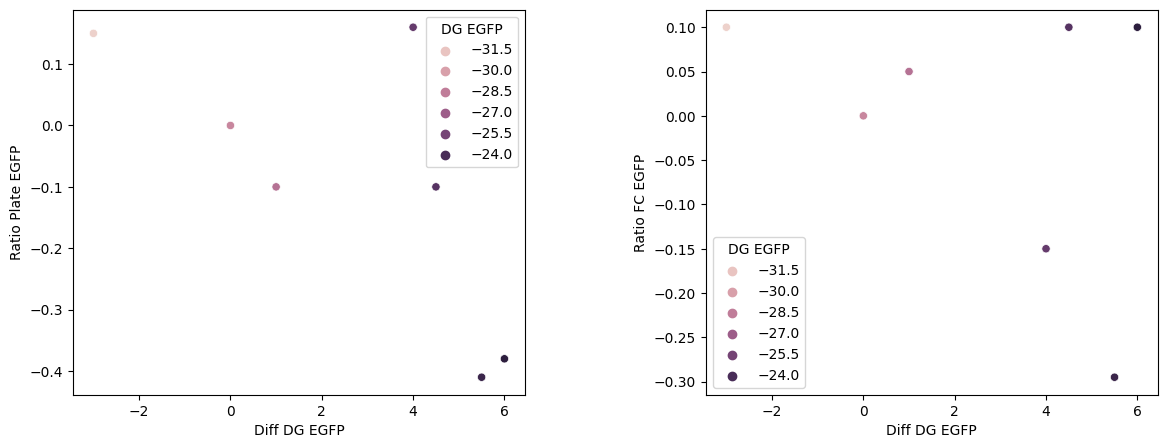

In [9]:
fig = plt.figure(figsize=(2*7,5))
fig.subplots_adjust(wspace=0.4)
ax = plt.subplot(1,2,1)
sns.scatterplot(data, x="Diff DG EGFP", y="Ratio Plate EGFP", hue='DG EGFP')
ax = plt.subplot(1,2,2)
sns.scatterplot(data, x="Diff DG EGFP", y="Ratio FC EGFP", hue='DG EGFP')

## Structure

Syn_ChiX_20-D
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).......................................((((((((((....))))))))))......', '-o', '/tmp/tmpze7ty2qd.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmpze7ty2qd.png



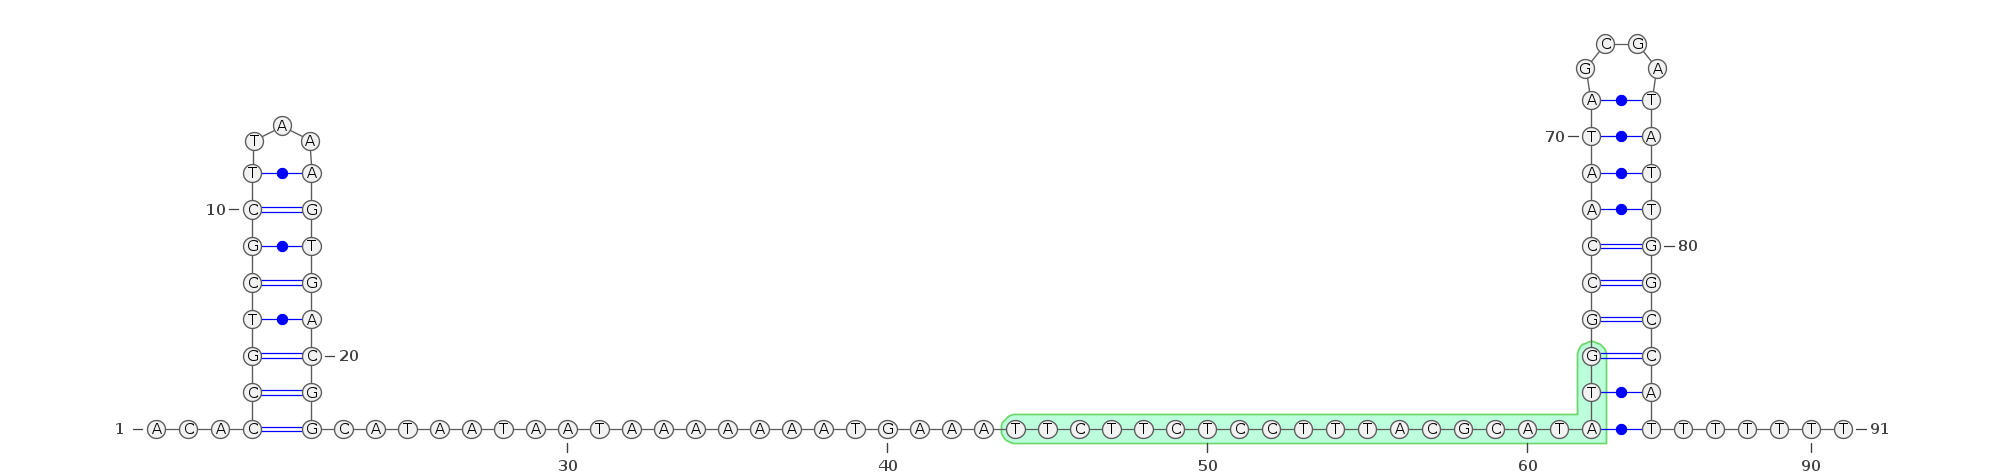

MutagenesisVariant_16
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCACCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...))))))))................((((....))))...........((((((((((....))))))))))......', '-o', '/tmp/tmp9bq5wuht.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmp9bq5wuht.png



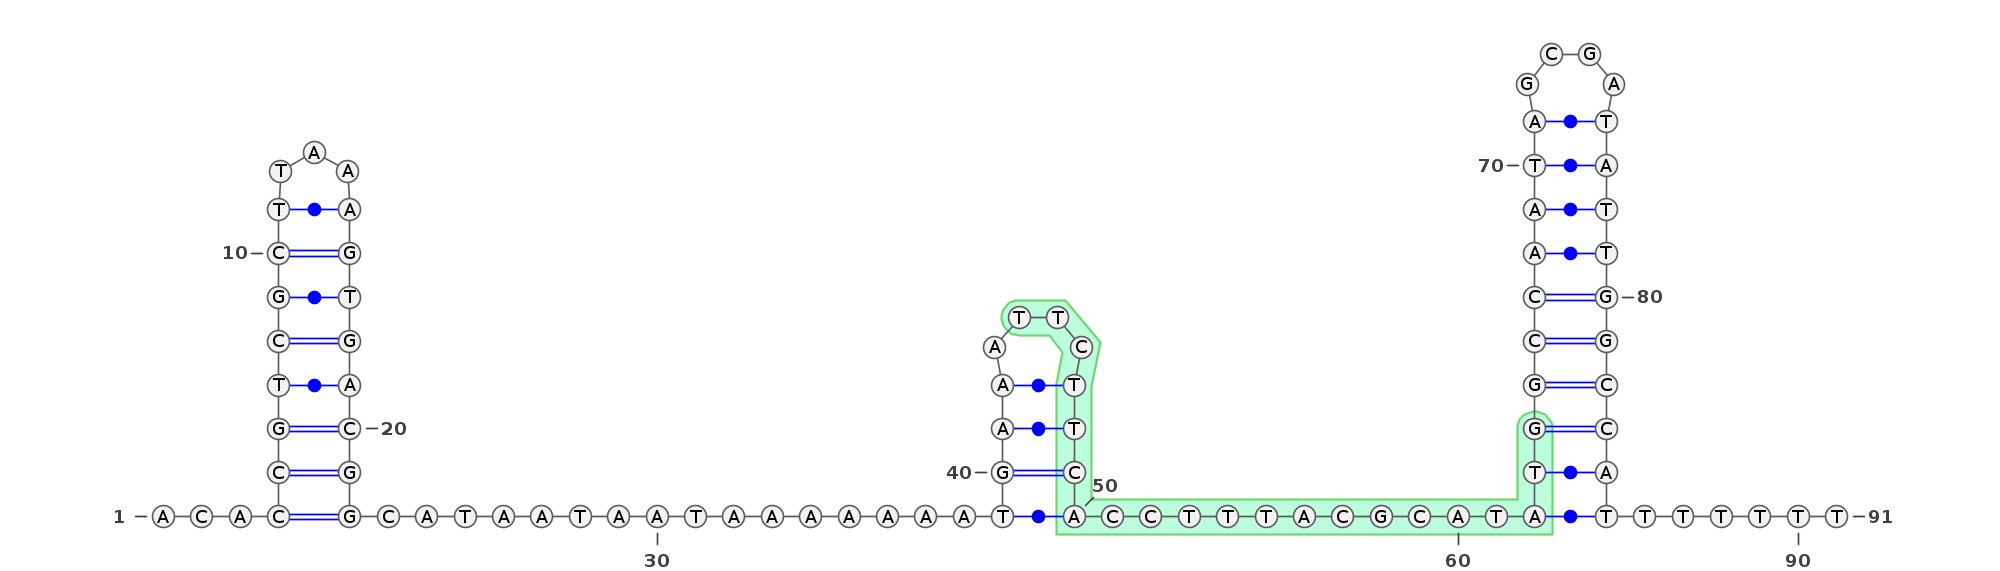

MutagenesisVariant_18
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCGCCTTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...))))))))...........................((......))..((((((((((....))))))))))......', '-o', '/tmp/tmpt9h4z9m0.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmpt9h4z9m0.png



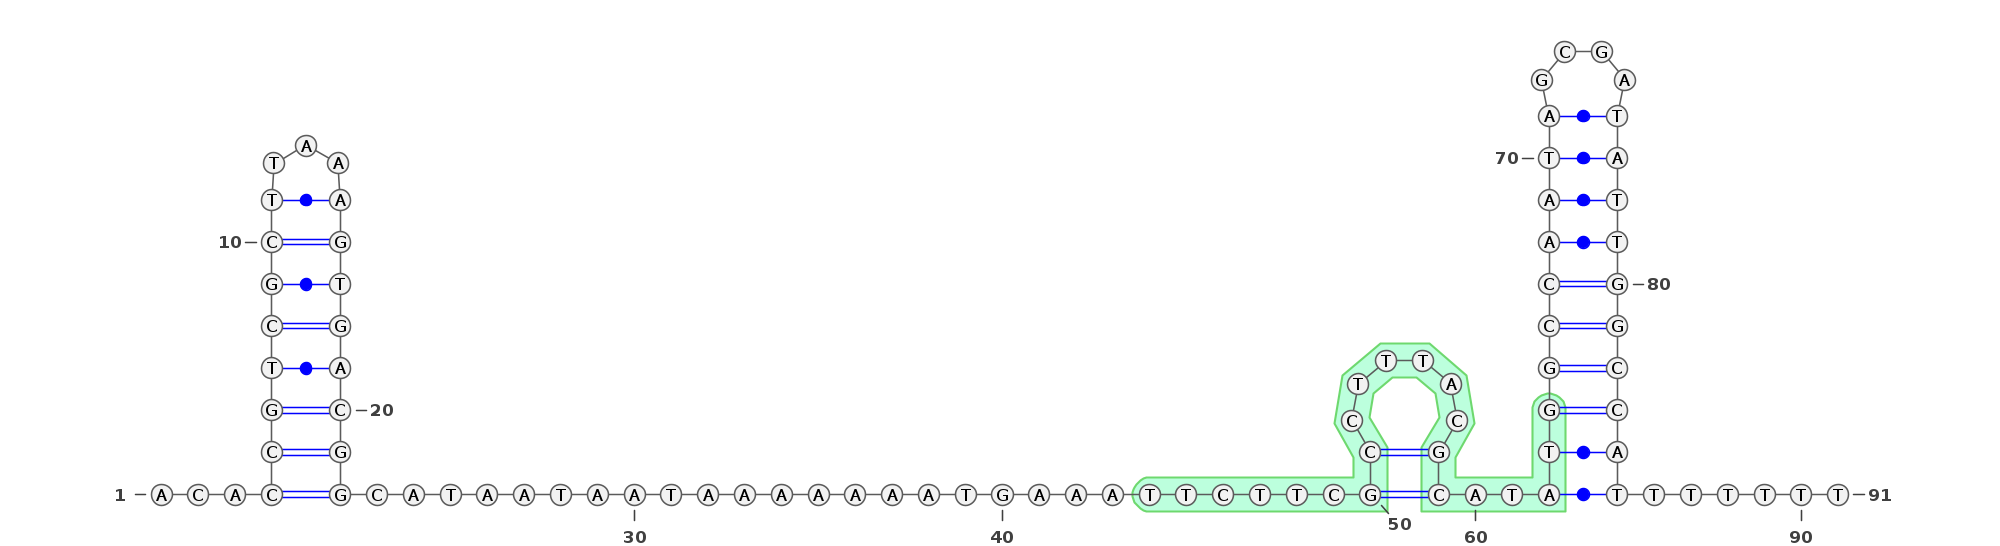

MutagenesisVariant_27
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCGTTACGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).......................................((((((((((....))))))))))......', '-o', '/tmp/tmpnmefmb2a.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmpnmefmb2a.png



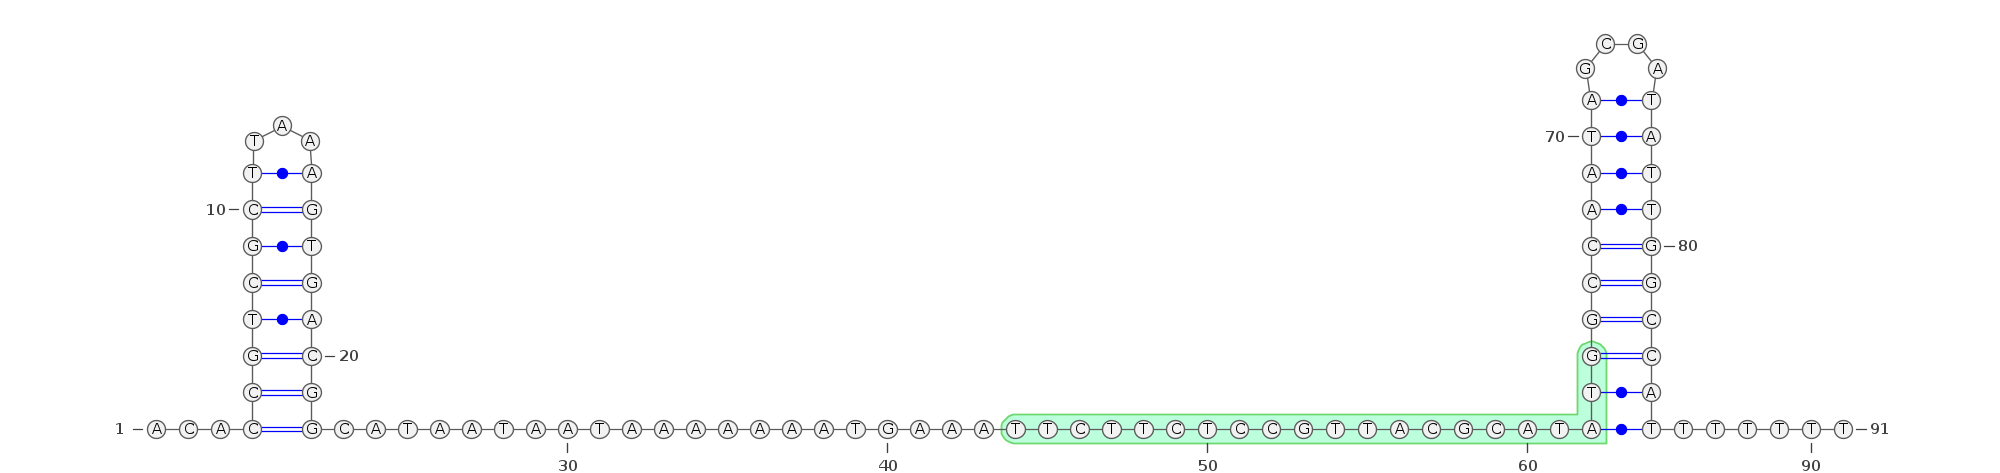

MutagenesisVariant_39
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTAGGCATATGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).......................................((((((((((....))))))))))......', '-o', '/tmp/tmp2h0zlvmy.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmp2h0zlvmy.png



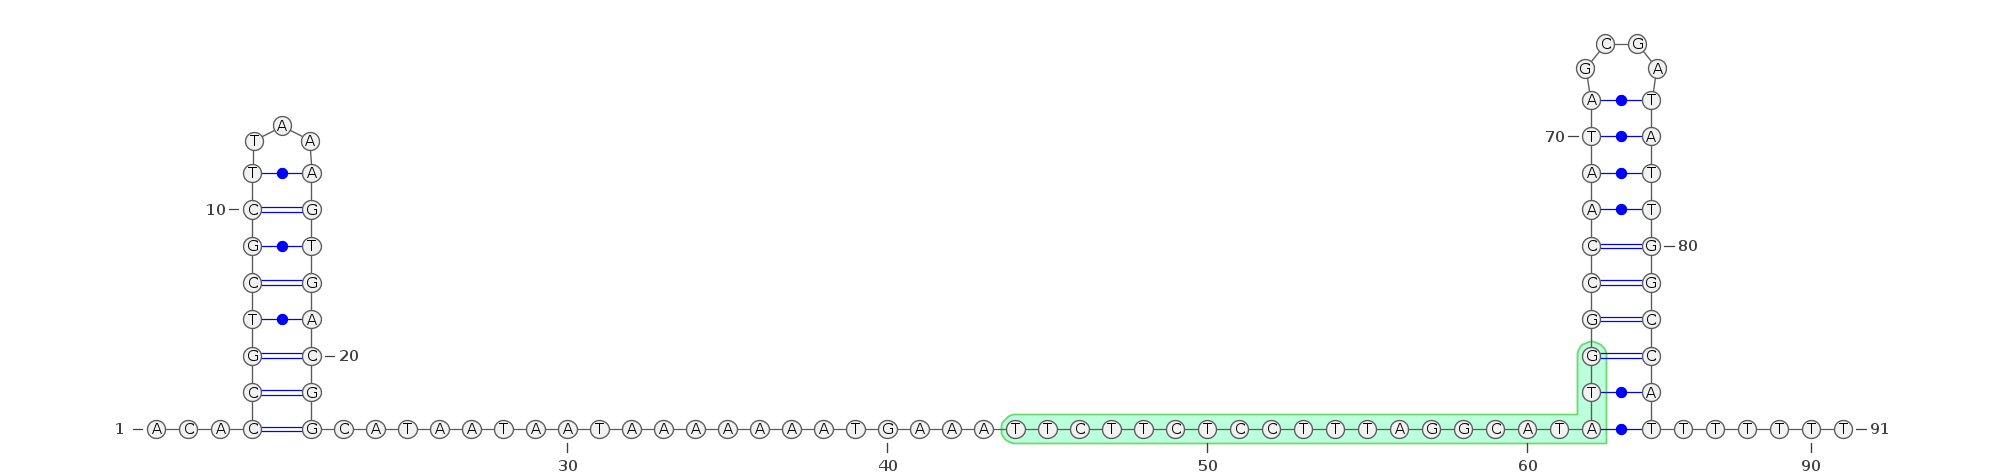

MutagenesisVariant_60
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'ACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATCGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...((((((((...)))))))).........(((((((((........................(((((((....))))))))))))))))', '-o', '/tmp/tmprhewbrsr.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmprhewbrsr.png



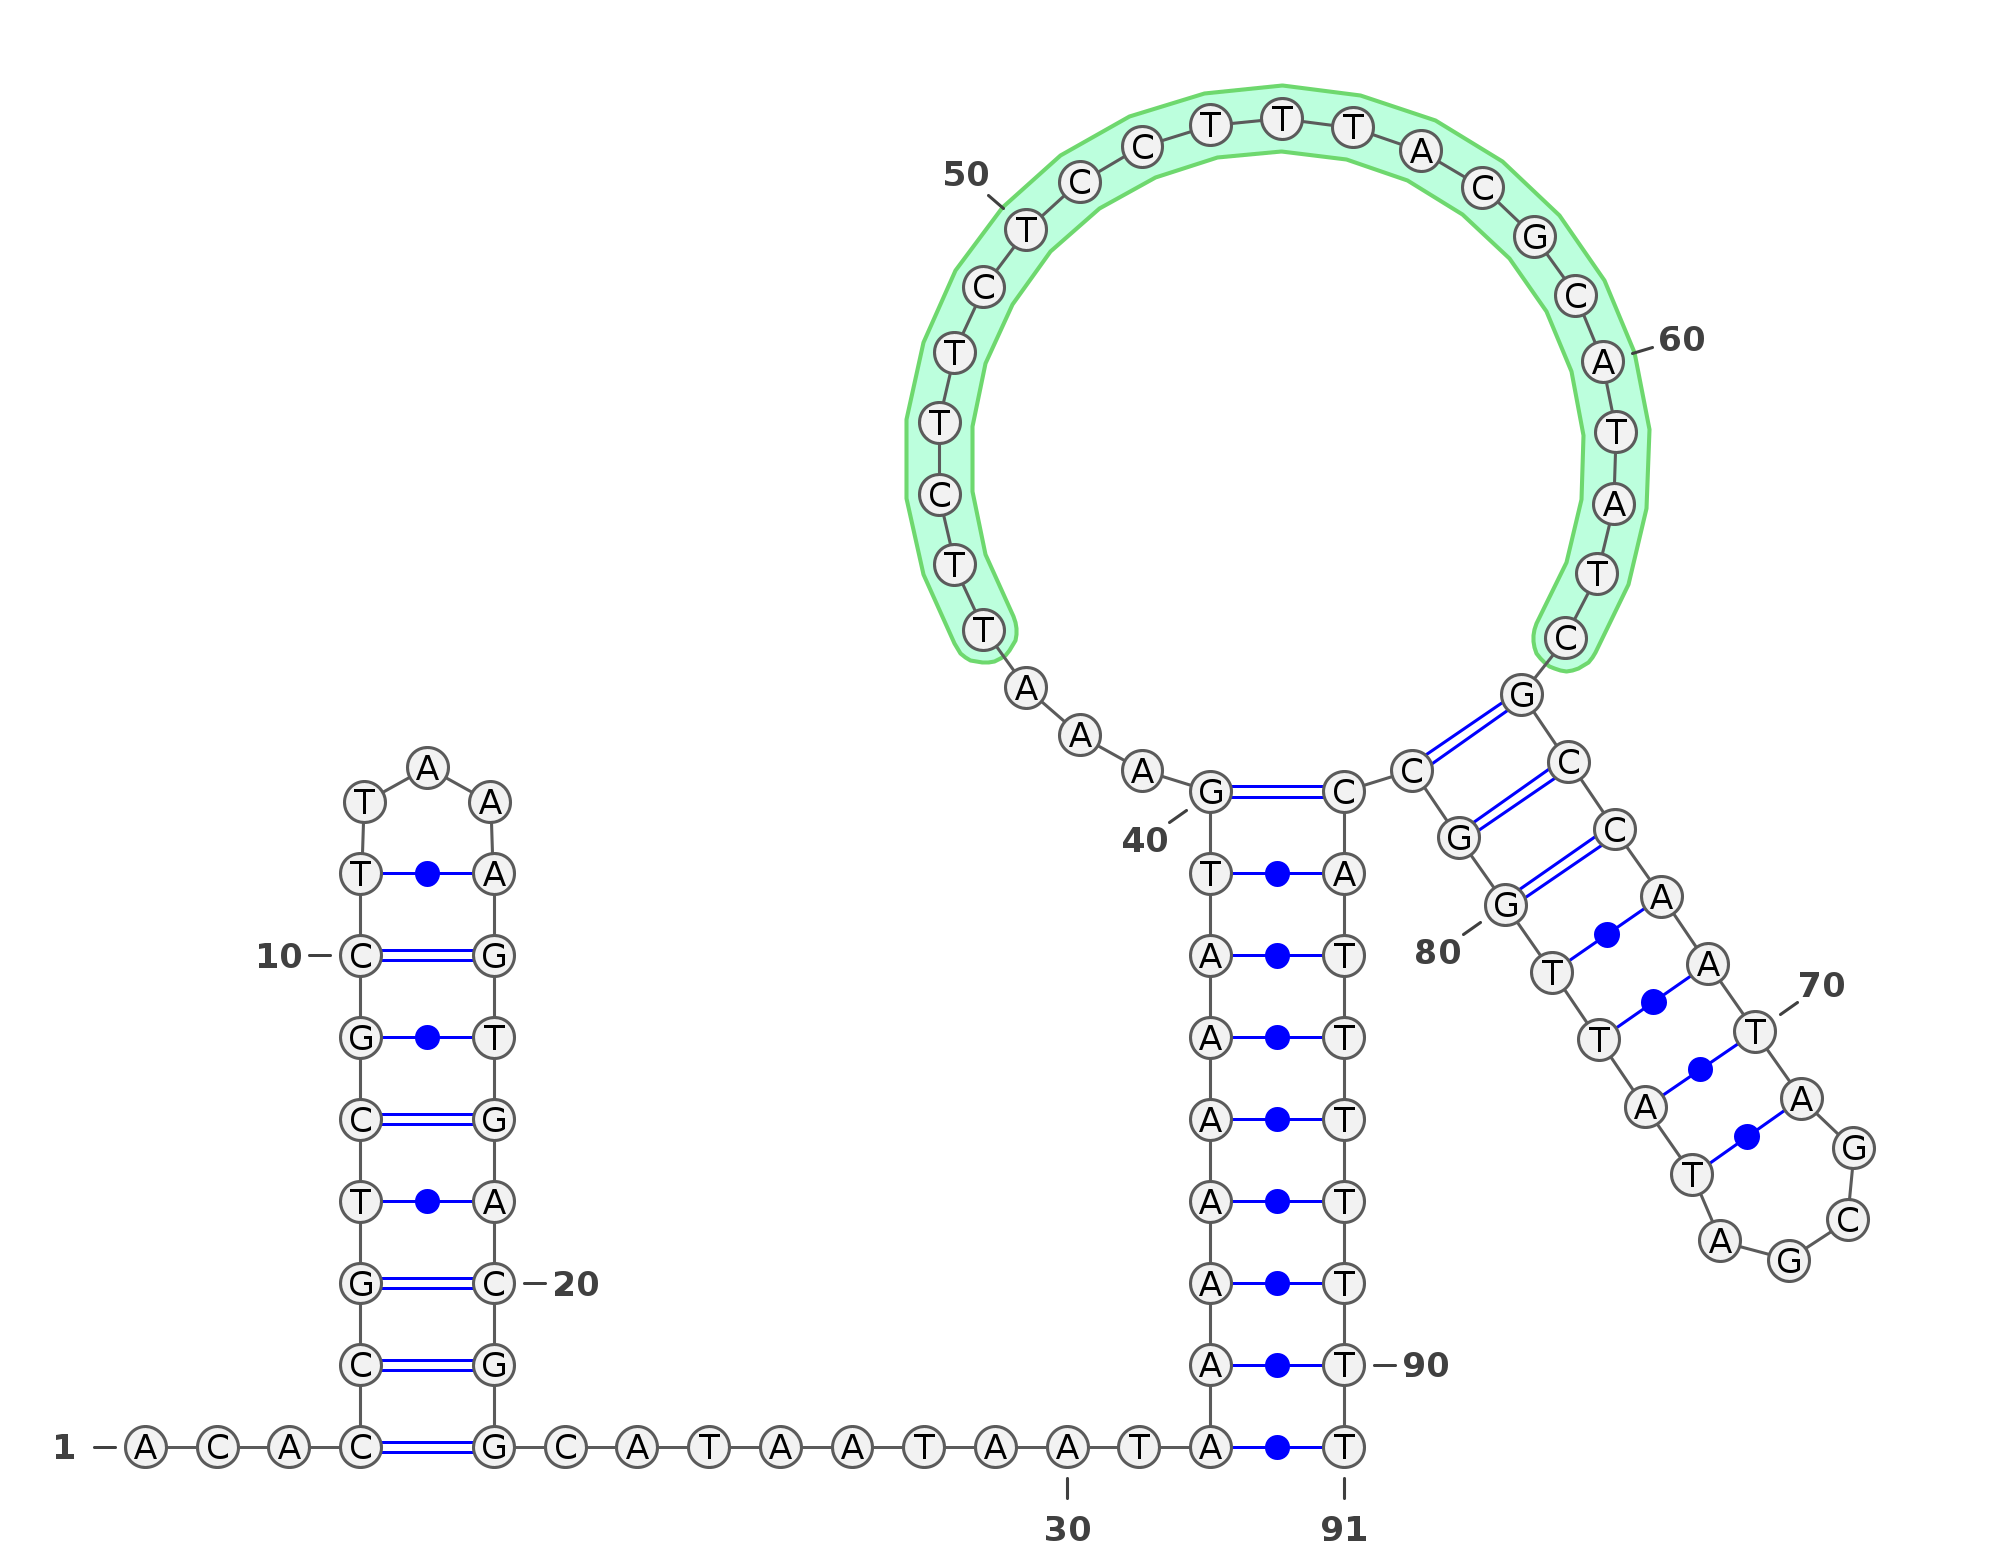

MutagenesisVariant_164
['java', '-cp', './VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'AACGGGTGTGCTTCCCGTTCTGATGAGTCCGTGAGGACGAAAGCGCCTCTACAAATAATTTTGTTTAAACACCGTCGCTTAAAGTGACGGCATAATAATAAAAAAATGAAATTCTTCTCCTTTACGCATATGGGCCAATAGCGATATTGGCCATTTTTTT', '-structureDBN', '...(((.((((((..((((((.(((....))).)))))).))))))))).........(((((((......((((((((...))))))))......))))))).............................((((((((....))))))))........', '-o', '/tmp/tmpznku1fre.png', '-resolution', '5', '-highlightRegion', '44-64']


Output file: /tmp/tmpznku1fre.png



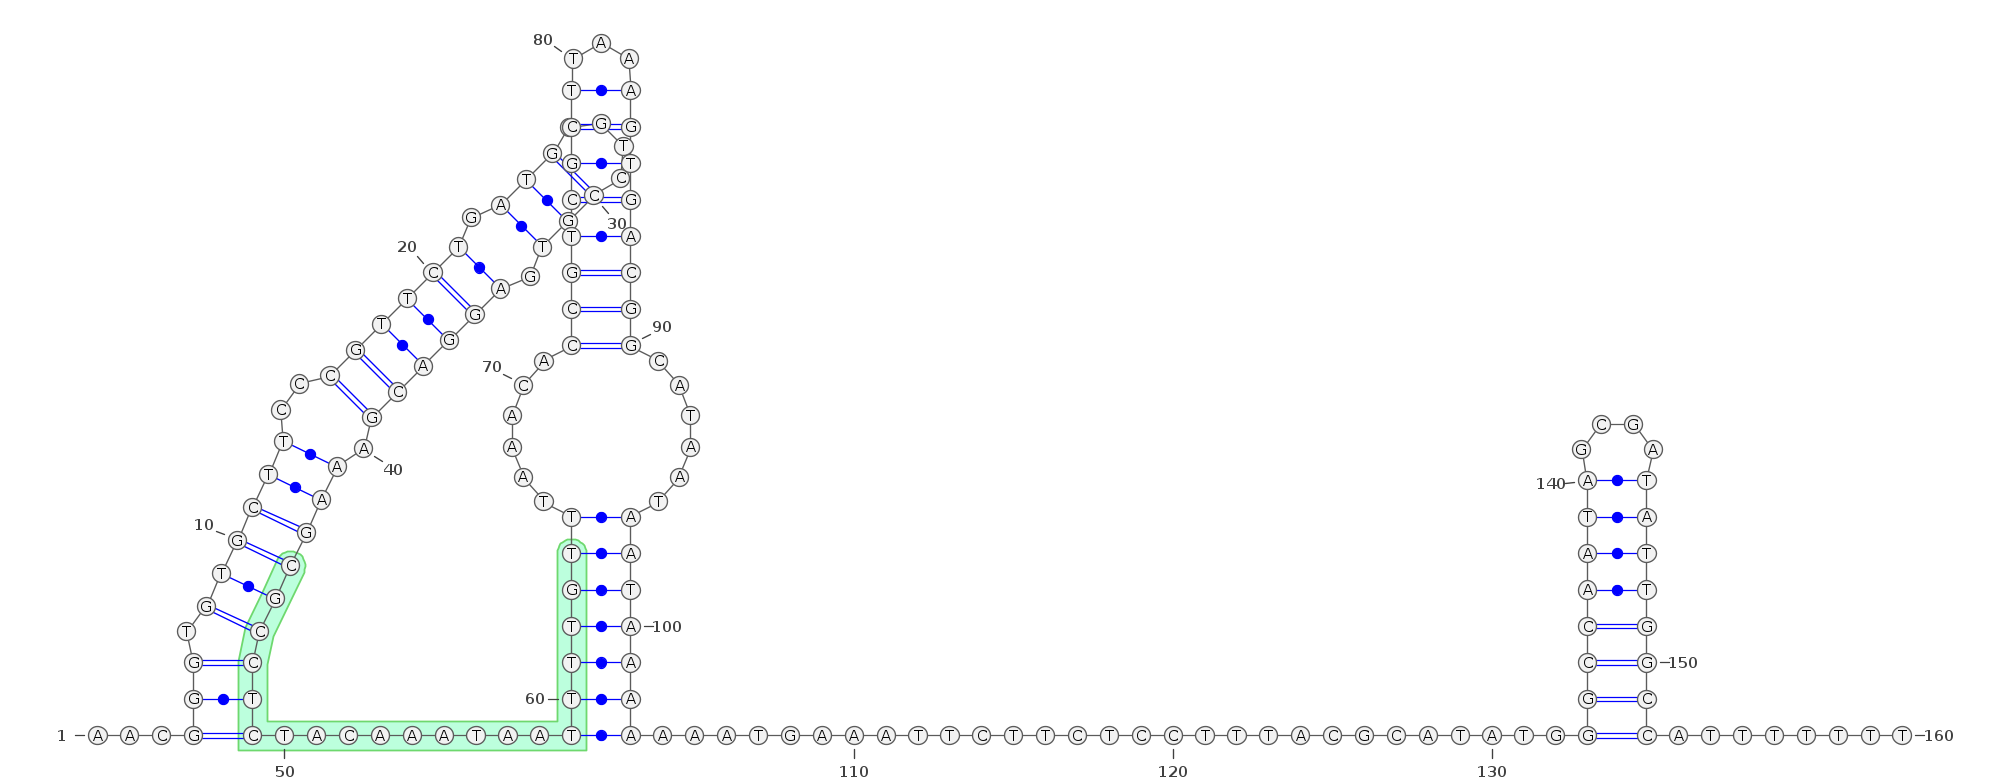

In [10]:
s = ''
for rna, seq in submuts.items():
    print(rna)
    folded = ViennaRNA.fold(seq, s)

    # v = Structure(structure=folded[0], sequence=seq)
    # v._params['resolution'] = 7
    # v.show()
    # v.savefig("example.png", show=True)

    show_rna_structure(folded[0], seq, resolution=5,
                       highlight_kwrgs={
                           'i': 44,
                           'j': 64
                           #    'i': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedStart1']),
                           #    'j': int(sim_data_l['Syn_ChiX_20-D']['cyRFP1']['seedEnd1'])
                       })